In [142]:
import requests
from time import sleep

# Jeton d'authentification pour augmenter la limite de requêtes


# Fonction pour rechercher des utilisateurs
def search_users(query, auth_token=None, max_users=10):
    users = []
    page = 1
    headers = {}
    if auth_token:
        headers["Authorization"] = f"token {auth_token}"
    
    while len(users) < max_users:
        url = f"https://api.github.com/search/users?q={query}&page={page}&per_page=100"
        response = requests.get(url, headers=headers)
        
        if response.status_code == 403:  # Limite de requêtes atteinte
            print("Limite atteinte, pause de 60 secondes...")
            sleep(60)
            continue
        
        if response.status_code != 200:
            print(f"Erreur lors de la recherche d'utilisateurs: {response.status_code}")
            break
        
        data = response.json()
        items = data.get("items", [])
        
        if not items:  # Fin de la pagination
            break
        
        users.extend([user["login"] for user in items])
        page += 1
        sleep(1)
        
    return users[:max_users]

def get_user_details(user, auth_token=None):
    headers = {}
    if auth_token:
        headers["Authorization"] = f"token {auth_token}"
    
    url = f"https://api.github.com/users/{user}"
    response = requests.get(url, headers=headers)
    
    if response.status_code == 403:  # Limite de requêtes atteinte
        print("Limite atteinte, pause de 60 secondes...")
        sleep(60)
        return get_user_details(user, auth_token)
    
    if response.status_code != 200:
        print(f"Erreur lors de la récupération des détails de {user}: {response.status_code}")
        return None
    
    return response.json()

# Fonction pour récupérer les dépôts d'un utilisateur
def get_repos(user, auth_token=None):
    repos = []
    page = 1
    headers = {}
    
    if auth_token:
        headers["Authorization"] = f"token {auth_token}"
    
    while True:
        url = f"https://api.github.com/users/{user}/repos?page={page}&per_page=100"
        response = requests.get(url, headers=headers)
        
        if response.status_code == 403:  # Limite de requêtes atteinte
            print("Limite atteinte, pause de 60 secondes...")
            sleep(60)
            continue
        
        if response.status_code != 200:
            print(f"Erreur lors de la récupération des dépôts de {user}: {response.status_code}")
            break
        
        data = response.json()
        if not data:  # Fin de la pagination
            break
        
        repos.extend(data)
        page += 1
        sleep(1)
        
    return repos

# Étape 1 : Rechercher des utilisateurs
query = "followers:>1000"  # Critère de recherche (utilisateurs ayant plus de 10 followers)
max_users = 10 # Nombre maximal d'utilisateurs à récupérer
user_list = search_users(query, auth_token, max_users)

# Étape 2 : Récupérer les dépôts de chaque utilisateur
all_repos = {}
user_details = {}

In [143]:
user_list

['torvalds',
 'yyx990803',
 'karpathy',
 'gustavoguanabara',
 'openai',
 'gaearon',
 'microsoft',
 'peng-zhihui',
 'ruanyf',
 'bradtraversy']

In [144]:
# Étape 2 : Récupérer les dépôts et détails de chaque utilisateur
all_data = {}  # Contiendra les dépôts et les détails des profils

for user in user_list:
    print(f"Récupération des détails de {user}...")
    user_details = get_user_details(user, auth_token)
    all_data[user] = {
        "details": user_details
    }


Récupération des détails de torvalds...
Récupération des détails de yyx990803...
Récupération des détails de karpathy...
Récupération des détails de gustavoguanabara...
Récupération des détails de openai...
Récupération des détails de gaearon...
Récupération des détails de microsoft...
Récupération des détails de peng-zhihui...
Récupération des détails de ruanyf...
Récupération des détails de bradtraversy...


In [145]:
user = user_list[0]
print(f"Récupération des dépôts de {user}...")
repos = get_repos(user, auth_token)
#print(repos)

Récupération des dépôts de torvalds...


In [146]:
features = []  # Contiendra les caractéristiques des dépôts
repo_names = []  # Pour sauvegarder les noms des dépôts

for user in user_list:
    print(f"Récupération des dépôts de {user}...")
    repos = get_repos(user, auth_token)
    all_repos[user] = repos
    details = all_data[user]
    user_details = get_user_details(user, auth_token)
    for repo in repos:
        name = " ".join(repo.get('name', ''))
        topics = " ".join(repo.get('topics', []))
        description = repo.get('description', '')
        language = repo.get('language', '')
        inf = ""
        user_detail = " "
        if details:
            inf += details.get('name', 'N/A')
            inf += " "
            inf += details.get('bio', 'N/A')
            inf += " "
            inf += details.get('company', 'N/A')
        user_detail += inf
        features.append([language, name, description, user_detail, topics])
        repo_names.append(f"{user}/{name}")

Récupération des dépôts de torvalds...
Récupération des dépôts de yyx990803...
Récupération des dépôts de karpathy...
Récupération des dépôts de gustavoguanabara...
Récupération des dépôts de openai...
Récupération des dépôts de gaearon...
Récupération des dépôts de microsoft...
Récupération des dépôts de peng-zhihui...
Récupération des dépôts de ruanyf...
Récupération des dépôts de bradtraversy...


In [147]:
features[0]

['C',
 'l i b d c - f o r - d i r k',
 "Only use for syncing with Dirk, don't use for anything else",
 ' N/A N/A N/A',
 '']

In [148]:
text_features = [" ".join(feature) for feature in features]  # Convert lists to space-separated strings
tfidf_matrix = vectorizer.fit_transform(text_features).toarray()

TypeError: sequence item 0: expected str instance, NoneType found

In [149]:
for feature in features:
    for i in range (len(feature)):
        if feature[i] == None:
            feature[i] = "null"

In [150]:
features[1][4]

''

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tf1 = vectorizer.fit_transform(features[0]).toarray()
tf2 = vectorizer.fit_transform(features[1]).toarray()
tf3 = vectorizer.fit_transform(features[2]).toarray()
tf4 = vectorizer.fit_transform(features[3]).toarray()
tf5 = vectorizer.fit_transform(features[4]).toarray()

In [152]:
tf4.shape

(5, 4)

In [153]:
# Étape 4 : Ajout des caractéristiques numériques (stars et forks)
#numeric_features = np.array([feature[4] for feature in features])
combined_features = np.hstack((tf5,tf1,tf2,tf3,tf4))

In [154]:
# Étape 5 : Normalisation des données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(combined_features)

In [155]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(combined_features)

In [156]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
features_scaled = scaler.fit_transform(combined_features)


In [157]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
features_scaled = scaler.fit_transform(combined_features)


In [158]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
features_scaled = scaler.fit_transform(combined_features)


In [159]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Suppose que combined_features contient à la fois des features numériques et textuelles
numerical_features = combined_features[:, :3]  # Suppose que les 3 premières colonnes sont numériques
text_features = combined_features[:, 3:]  # Suppose que les autres colonnes sont textuelles

# Normalisation des colonnes numériques uniquement
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# Combinaison des features normalisées et textuelles
features_scaled = np.hstack((numerical_features_scaled, text_features))


In [163]:
# Étape 6 : Application de KMeans
from sklearn.cluster import KMeans
n_clusters = 2  # Nombre de clusters souhaités
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)

C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [164]:
kmeans.fit(features_scaled)

C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [165]:
new_text_features = ["Exemple de texte à transformer en TF-IDF"]  # Remplacez par vos données
numeric_features_new = np.array([[3.5, 10]])  # Remplacez par vos valeurs numériques

# Appliquer le même vectoriseur TF-IDF que celui utilisé lors de l'entraînement
tfidf_new = vectorizer.transform(new_text_features).toarray()  # Résultat : (1, 1000)

# Combiner les caractéristiques numériques et TF-IDF
new_element_processed = np.hstack((numeric_features_new, tfidf_new))  # Résultat : (1, 1002)


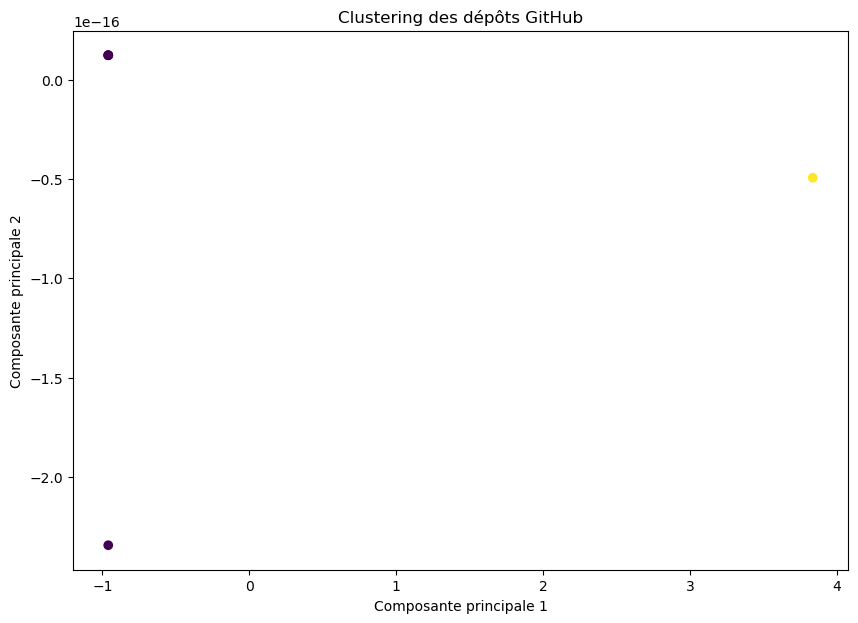

In [166]:
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

# Étape 7 : Réduction de dimension pour visualisation
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)

# Affichage des clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.title("Clustering des dépôts GitHub")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_38484\3188872967.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', cmap='viridis')


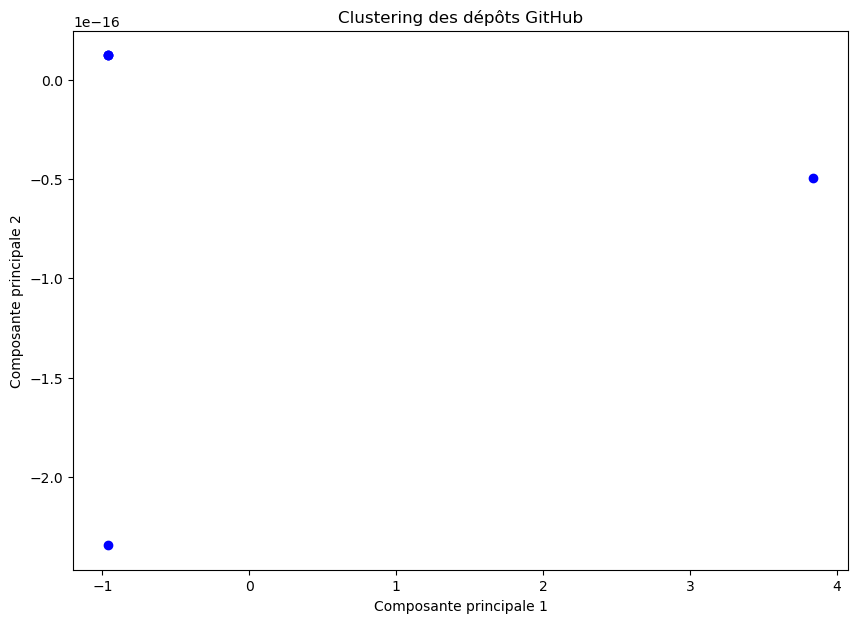

In [167]:
# Affichage des clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', cmap='viridis')
plt.title("Clustering des dépôts GitHub")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

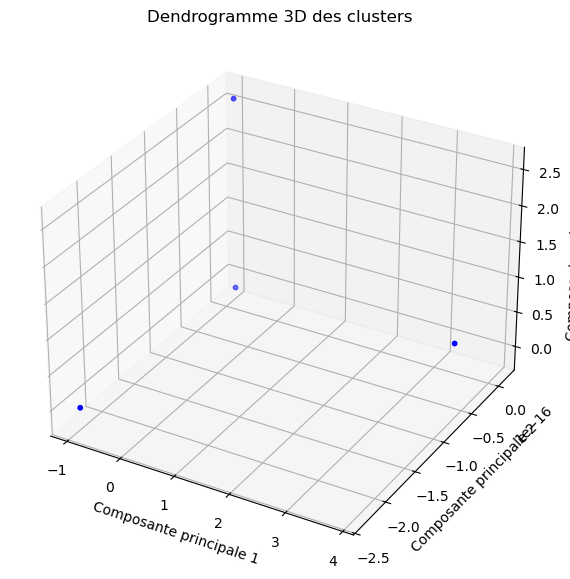

In [168]:

# Étape 1 : Calcul de la matrice de liaison
linkage_matrix = shc.linkage(features_scaled, method='ward')

# Étape 2 : Réduction de dimension à 3 composantes principales avec PCA
pca = PCA(n_components=3)
features_reduced = pca.fit_transform(features_scaled)

# Étape 3 : Création d'un graphique 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Affichage des points (données réduites)
ax.scatter(features_reduced[:, 0], features_reduced[:, 1], features_reduced[:, 2], c='blue', s=10)

# Étape 4 : Création d'un dendrogramme 3D
for i, (x, y, z) in enumerate(features_reduced):
    ax.text(x, y, z, "", fontsize=1)  # Affiche l'étiquette des points

# Personnalisation de l'affichage
ax.set_title("Dendrogramme 3D des clusters")
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_zlabel("Composante principale 3")

plt.show()

In [169]:
# Étape 2 : Récupérer les dépôts et descriptions de chaque utilisateur
descriptions = []  # Stockera les descriptions agrégées des projets pour chaque utilisateur
usernames = []  # Pour sauvegarder les noms des utilisateurs

for user in user_list:
    print(f"Récupération des dépôts de {user}...")
    repos = get_repos(user, auth_token)
    
    repo_descriptions = " ".join(repo.get('description', '') for repo in repos if repo.get('description'))
    repo_names = " ".join(repo.get('name', '') for repo in repos)
    combined_text = f"{repo_descriptions} {repo_names}"
    
    descriptions.append(combined_text)
    usernames.append(user)

Récupération des dépôts de torvalds...
Récupération des dépôts de yyx990803...
Récupération des dépôts de karpathy...
Récupération des dépôts de gustavoguanabara...
Récupération des dépôts de openai...
Récupération des dépôts de gaearon...
Récupération des dépôts de microsoft...
Récupération des dépôts de peng-zhihui...
Récupération des dépôts de ruanyf...
Récupération des dépôts de bradtraversy...


In [ ]:
import scipy.cluster.hierarchy as shc
# Étape 3 : Vectorisation des descriptions avec TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
features = vectorizer.fit_transform(descriptions).toarray()

# Étape 4 : Normalisation des données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


plt.figure(figsize=(10, 7))
plt.title("WINES DENDROGRAMS")
dend = shc.dendrogram(shc.linkage(features_scaled, method='ward'))

In [ ]:
shc.linkage(features_scaled, method='ward')

In [137]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')
types = cluster.fit_predict(features_scaled)
types

array([0, 0, 1, 0, 0], dtype=int64)

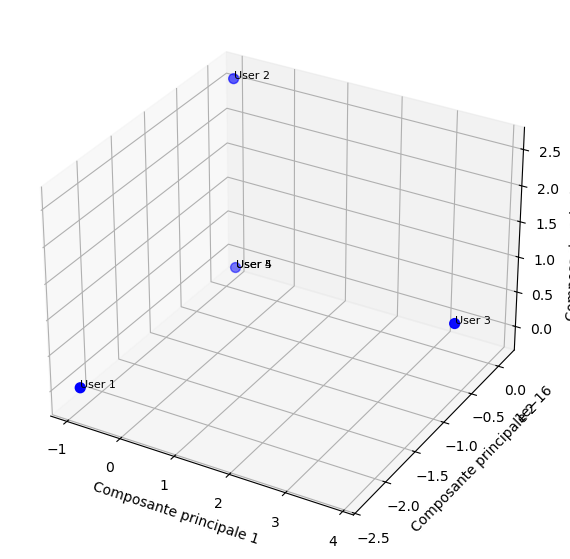

In [172]:
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Étape 1 : Calcul de la matrice de liaison
linkage_matrix = shc.linkage(features_scaled, method='ward')

# Étape 2 : Réduction de dimension à 3 composantes principales avec PCA
pca = PCA(n_components=3)
features_reduced = pca.fit_transform(features_scaled)

# Étape 3 : Création d'un graphique 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Affichage des points (données réduites)
ax.scatter(features_reduced[:, 0], features_reduced[:, 1], features_reduced[:, 2], c='blue', s=50)

# Étape 4 : Création d'un dendrogramme 3D
for i, (x, y, z) in enumerate(features_reduced):
    ax.text(x, y, z, f"User {i+1}", fontsize=8)  # Affiche l'étiquette des points

# Personnalisation de l'affichage
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_zlabel("Composante principale 3")

plt.show()


In [9]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition

mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")

In [21]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlflow.client import MlflowClient

# Start MLflow experiment




with mlflow.start_run():
    mlflow.set_tag("author", "alice")
    mlflow.set_tag("experiment_type", "baseline")
    # Log parameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 5)
    
    # Load data and train model
    data = load_iris()
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Log metrics
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    signature = infer_signature(X_train, model.predict(X_train))
    
    # Log model
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="random_forest_model",
        signature=signature,
        input_example=X_train,
        registered_model_name='test-model',
        alias="champion",
        
    )

    
    
    client = MlflowClient(mlflow.get_tracking_uri())
    model_info = client.get_model_version_by_alias(
        name="test-model",
        alias="champion"
    )
    client.set_model_version_tag(
        name='test-model',
        version=model_info.version,
        key='task',
        value='regression'
    )

    # Log artifacts (e.g., plots, requirements)
    mlflow.log_artifact("../environment.yml")
    
    # Set tags
    


🏃 View run valuable-hog-660 at: http://127.0.0.1:8081/#/experiments/0/runs/16e75a56905a4259af5fbded46ede6a8
🧪 View experiment at: http://127.0.0.1:8081/#/experiments/0


TypeError: log_model() got an unexpected keyword argument 'alias'

In [4]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

In [18]:
client.set_model_version_aliase(
        name='test-model',
        version=model_info.version,
        key='name',
        value='test'
    )

AttributeError: 'MlflowClient' object has no attribute 'set_model_version_aliase'